# Classification for binary, ternary and Bethesda
Features selected by Multivariate Analysis are here used to validate performance
We execute the models using a 10-fold cross validation with upsampling of test data    

In [1]:
import os
import sys

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

In [3]:
import numpy as np
import pandas as pd
from math import sqrt
from PIL import Image
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs
from sklearn import preprocessing
from datetime import datetime
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, norm
from utils import functions

In [4]:
## Parameters sugested by gridsearch for models (see tuning.ipynb)
svm_param =  {'C': 100, 'kernel': 'linear'}
rf_param = {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50}
xgb_param = {'learning_rate': 0.1, 'n_estimators': 86, 'max_depth': 9, 'min_child_weight':1,
              'gamma':0, 'subsample':0.9, 'colsample_bytree':0.7, 'reg_alpha': 0.001}

In [5]:
classifiers = ['SVM', 'RF', 'XGBoost']
params = [svm_param, rf_param, xgb_param]

## Features selected

In [6]:
selected_features = ['fdN1', 'fdN22', 'fdN26', 'fdN28']

print(selected_features) 
id_columns = ['bethesda', 'image_id', 'cell_id']
all_columns = id_columns + selected_features
print(f'\nNº total de de features: {len(selected_features)}')  

['fdN1', 'fdN22', 'fdN26', 'fdN28']

Nº total de de features: 4


### Read data cell features (normalized)

In [7]:
normalized_cell_features= pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'files', 'normalized_features.csv'), index_col=0)
normalized_cell_features = normalized_cell_features[all_columns]

In [8]:
df_nilm, df_ascus, df_lsil, df_asch, df_hsil, df_scc = functions.split_per_classes(normalized_cell_features)

--- Samples per class  --- 
NILM.....:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
SCC......:  77
TOTAL....:  3233


In [9]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= functions.split_data_targe_ids(df_nilm, df_ascus, \
                       df_lsil, df_asch, df_hsil,df_scc)
 

#Cross-validation in 10k-folds and upsample (using SMOTE or BorderlineSMOTE) on train data:

### Binary Classification - Normal(0) vs Anormal (1-5)


In [10]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# DataFrame of metric results
results = pd.DataFrame(np.empty((3,10), dtype=object), index = np.arange(3), columns=['Experiment', 'Model', 'Features', 'Accuracy', 'Precision', 'Recall' , 'False Pos', 'False Neg', 'Specificity', 'F1_measure'])
classifiers = ['SVM', 'RF', 'XGBoost']
features_desc= "Sel features N/C"
N_SPLITS = 10 

In [11]:
for ci in range(3):
    # Executa cross-validation e mostra curvas ROC
    cv = StratifiedKFold(n_splits= N_SPLITS)
    accs= np.zeros((N_SPLITS), dtype = np.float64)
    precs= np.zeros((N_SPLITS), dtype = np.float64)
    recs= np.zeros((N_SPLITS), dtype = np.float64)
    specs= np.zeros((N_SPLITS), dtype = np.float64)
    f1_scores= np.zeros((N_SPLITS), dtype = np.float64)
    aucs= np.zeros((N_SPLITS), dtype = np.float64)
    
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    preds_y = np.zeros(target.shape[0])

    ## Ajusta features para treino e teste
    X = data[selected_features].values
    data_y = target['binary'].values
    
    model = functions.getModel(params= params[ci], classifier = classifiers[ci], class_type = 'binary')
    for i, (train, test) in enumerate(cv.split(X, data_y)):
        # Fit Model (using data augmentation methods - see params for fit_model):
        _ , model = functions.fit_model(X[train], data_y[train], model, cls_type=1, smote=0)   # run binary classification in this fold whose fold samples will be modified by SMOTE data augmentation method 

        # Prediction:
        pred_y = model.predict(X[test])
        prob_y = model.predict_proba(X[test])

        #Save predictions:
        preds_y[test] = pred_y

        # Calc and save metric predictions for the fold:
        accs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='acc', class_type='binary', classes=[0,1])
        precs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='prec',class_type='binary', classes=[0,1])                
        recs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='rec',class_type='binary', classes=[0,1])                
        specs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='spec',class_type='binary', classes=[0,1])                
        f1_scores[i] = functions.calc_metric(data_y[test], pred_y, metric_type='f1_score',class_type='binary', classes=[0,1])        

        # Calcula curva_roc e AUC:
        prob = prob_y[:, 1]
        fpr, tpr, thresholds = roc_curve(data_y[test], prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs[i]= auc(mean_fpr, interp_tpr)

    ## Calc average metrics: False pos and false Negative are derived from specificity and recall, respectively
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
               'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
    results.loc[ci] = functions.fill_line_metrics_CV(classifiers[ci], features_desc, ci, metrics, results, class_type='binary')
       
    # Calcula e registra curva ROC (média CV) e confmatrix 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    roc_curve_list.append((mean_fpr, mean_tpr))
    label = r"Mean ROC (AUC %s= %0.4f $\pm$ %0.4f)" % ((classifiers[ci]+""), mean_auc, std_auc)
    labels_list.append(label)

    conf_matrix_list.append((data_y, preds_y, features_desc + "- Binary"+classifiers[ci]))
 
                  

### Binary Classification: results 

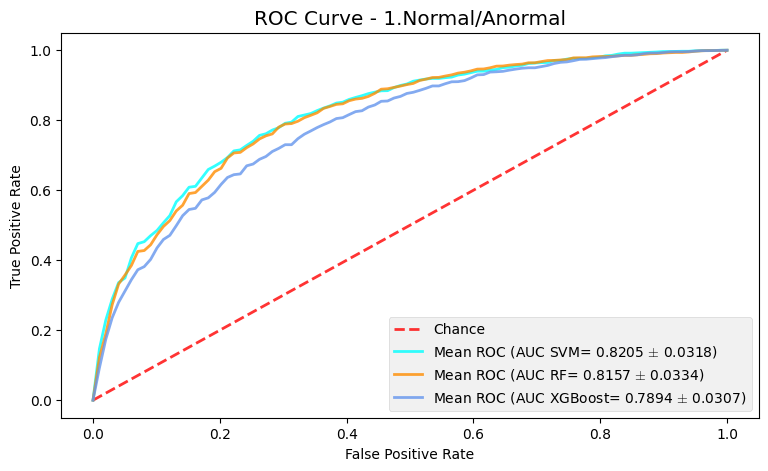

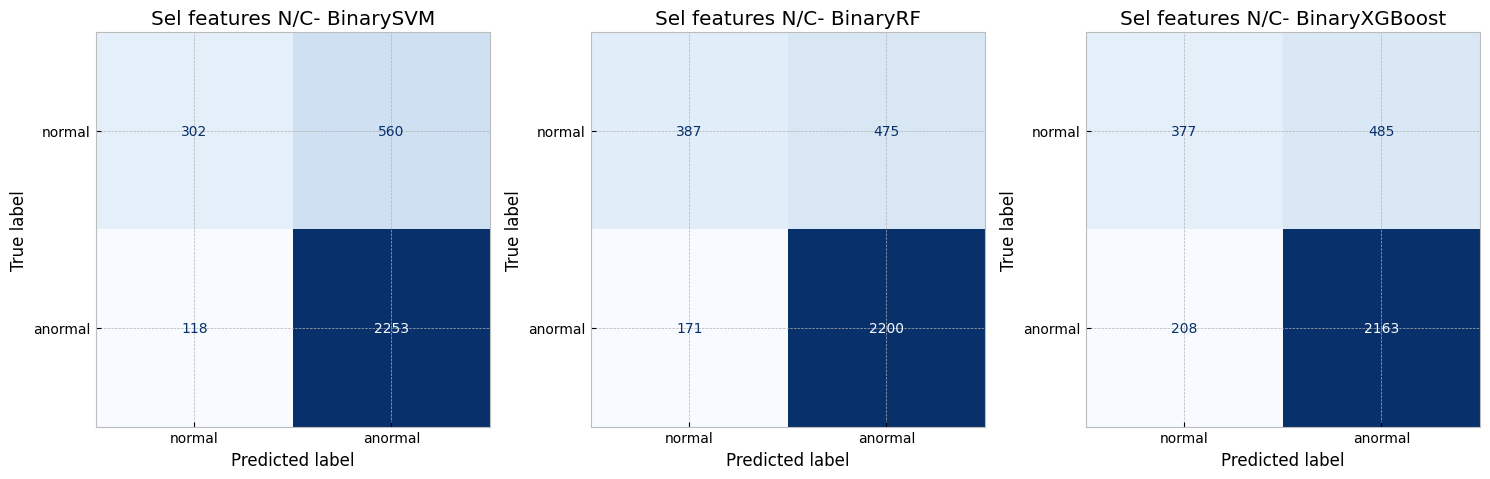

,Experiment,Model,Features,Accuracy,Precision,Recall,False Pos,False Neg,Specificity,F1_measure
0,binary,SVM,Sel features N/C,0.7903,0.8011,0.9502,0.6498,0.0498,0.3502,0.8693
1,binary,RF,Sel features N/C,0.8002,0.8228,0.9279,0.5512,0.0721,0.4488,0.8720
2,binary,XGBoost,Sel features N/C,0.7856,0.8171,0.9123,0.5628,0.0877,0.4372,0.8620


In [12]:
# Show all results:
functions.plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve - 1.Normal/Anormal")
functions.plot_conf_matrix(conf_matrix_list, lbls=[0,1], disp_lbls=['normal', 'anormal'])
results

** The problem seams to be 

### Ternary Classification - Normal(0), Low-grade (1,2), High-grade(3,4,5)

In [13]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# DataFrame of metric results
results = pd.DataFrame(np.empty((3,10), dtype=object), index = np.arange(3), columns=['Experiment', 'Model', 'Features', 'Accuracy', 'Precision', 'Recall' , 'False Pos', 'False Neg', 'Specificity', 'F1_measure'])
 
for ci in range(3):
    # Executa cross-validation e mostra curvas ROC
    cv = StratifiedKFold(n_splits= N_SPLITS)
    accs= np.zeros((N_SPLITS), dtype = np.float64)
    precs= np.zeros((N_SPLITS), dtype = np.float64)
    recs= np.zeros((N_SPLITS), dtype = np.float64)
    specs= np.zeros((N_SPLITS), dtype = np.float64)
    f1_scores= np.zeros((N_SPLITS), dtype = np.float64)
    aucs= np.zeros((N_SPLITS), dtype = np.float64)
    
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    preds_y = np.zeros(target.shape[0])

    ## Ajusta features para treino e teste
    X = data[selected_features].values
    data_y = target['ternary'].values
    
    model = functions.getModel(params= params[ci], classifier = classifiers[ci], class_type = 'multiclass')
    for i, (train, test) in enumerate(cv.split(X, data_y)):
        # Fit Model (using data augmentation methods - see params for fit_model):
        _, model = functions.fit_model(X[train], data_y[train], model, cls_type=1, smote=0)   # run binary classification in this fold whose fold samples will be modified by SMOTE data augmentation method 

        # Prediction:
        pred_y = model.predict(X[test])
        prob_y = model.predict_proba(X[test])

        #Save predictions:
        preds_y[test] = pred_y

        # Calc and save metric predictions for the fold:
        accs[i] =  functions.calc_metric(data_y[test], pred_y, metric_type='acc', class_type='multiclass', classes=[0,1,2])        
        precs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='prec',class_type='multiclass', classes=[0,1,2])          
        recs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='rec',class_type='multiclass',  classes=[0,1,2])          
        specs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='spec',class_type='multiclass', classes=[0,1,2])         
        f1_scores[i] = functions.calc_metric(data_y[test], pred_y, metric_type='f1_score',class_type='multiclass', classes=[0,1,2])         

   
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
               'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
    results.loc[ci] = functions.fill_line_metrics_CV(classifiers[ci], features_desc, ci, metrics, results, class_type='ternary')

    conf_matrix_list.append((data_y, preds_y, features_desc + "- Ternary"+classifiers[ci]))
           

#### Ternary Classifications Results

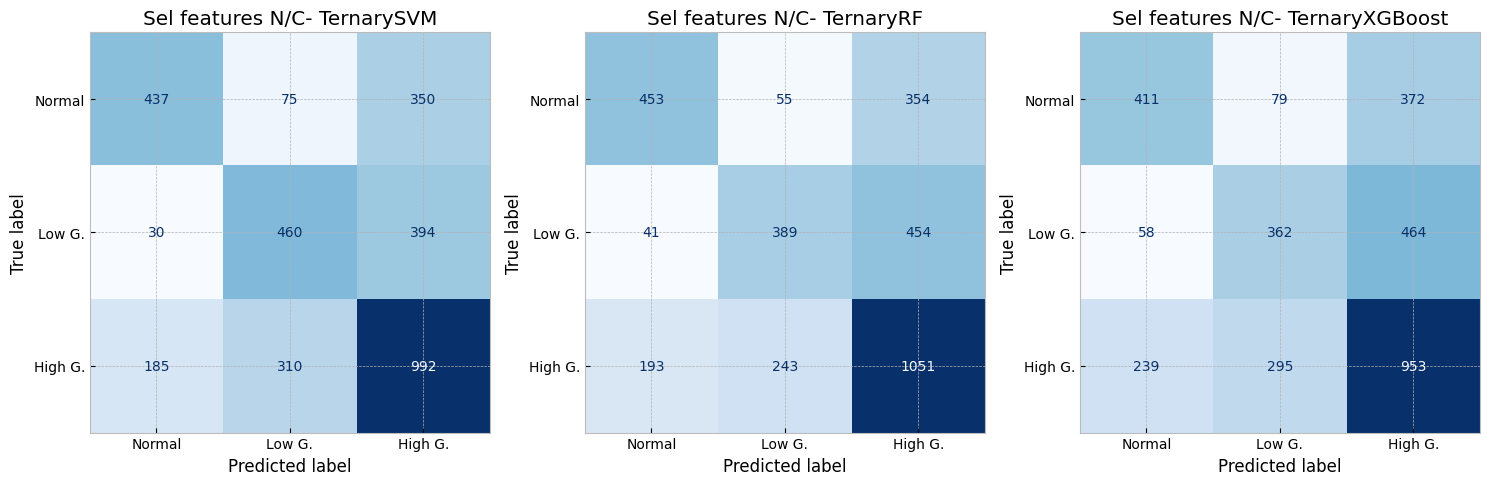

,Experiment,Model,Features,Accuracy,Precision,Recall,False Pos,False Neg,Specificity,F1_measure
0,ternary,SVM,Sel features N/C,0.5843,0.5914,0.5843,0.2269,0.4157,0.7731,0.5821
1,ternary,RF,Sel features N/C,0.5855,0.5920,0.5855,0.2294,0.4145,0.7706,0.5800
2,ternary,XGBoost,Sel features N/C,0.5339,0.5352,0.5339,0.2544,0.4661,0.7456,0.5289


In [14]:
# Show all results:
functions.plot_conf_matrix(conf_matrix_list, lbls=[0,1,2], disp_lbls=['Normal', 'Low G.', 'High G.'])
results

### Bethesda Classification - Normal(0), ASCUS(1), LSIL(2), ASCH(3), HSIL(5), SCC(5)

In [15]:
### Bethesda (6) Classification - 
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# DataFrame of metric results
results = pd.DataFrame(np.empty((3,10), dtype=object), index = np.arange(3), columns=['Experiment', 'Model', 'Features', 'Accuracy', 'Precision', 'Recall' , 'False Pos', 'False Neg', 'Specificity', 'F1_measure'])
for ci in range(3):
    # Executa cross-validation e mostra curvas ROC
    cv = StratifiedKFold(n_splits= N_SPLITS)
    accs= np.zeros((N_SPLITS), dtype = np.float64)
    precs= np.zeros((N_SPLITS), dtype = np.float64)
    recs= np.zeros((N_SPLITS), dtype = np.float64)
    specs= np.zeros((N_SPLITS), dtype = np.float64)
    f1_scores= np.zeros((N_SPLITS), dtype = np.float64)
    aucs= np.zeros((N_SPLITS), dtype = np.float64)
    
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    preds_y = np.zeros(target.shape[0])

    ## Ajusta features para treino e teste
    X = data[selected_features].values
    data_y = target['bethesda'].values
    
    model = functions.getModel(params= params[ci], classifier = classifiers[ci], class_type = 'multiclass')
    for i, (train, test) in enumerate(cv.split(X, data_y)):
        # Fit Model (using data augmentation methods - see params for fit_model):
        _, model = functions.fit_model(X[train], data_y[train], model, cls_type=1, smote=0)   # run binary classification in this fold whose fold samples will be modified by SMOTE data augmentation method 

        # Prediction:
        pred_y = model.predict(X[test])
        prob_y = model.predict_proba(X[test])

        #Save predictions:
        preds_y[test] = pred_y

        # Calc and save metric predictions for the fold:
        accs[i] =  functions.calc_metric(data_y[test], pred_y, metric_type='acc', class_type='multiclass')  #, classes=[0,1,2])        
        precs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='prec',class_type='multiclass')  
        recs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='rec',class_type='multiclass')  
        specs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='spec',class_type='multiclass') 
        f1_scores[i] = functions.calc_metric(data_y[test], pred_y, metric_type='f1_score',class_type='multiclass') 

    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
               'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
    results.loc[ci] = functions.fill_line_metrics_CV(classifiers[ci], features_desc, ci, metrics, results, class_type='bethesda')

    conf_matrix_list.append((data_y, preds_y, features_desc + "- Bethesda"+classifiers[ci]))
           

#### Bethesda Classifications Results

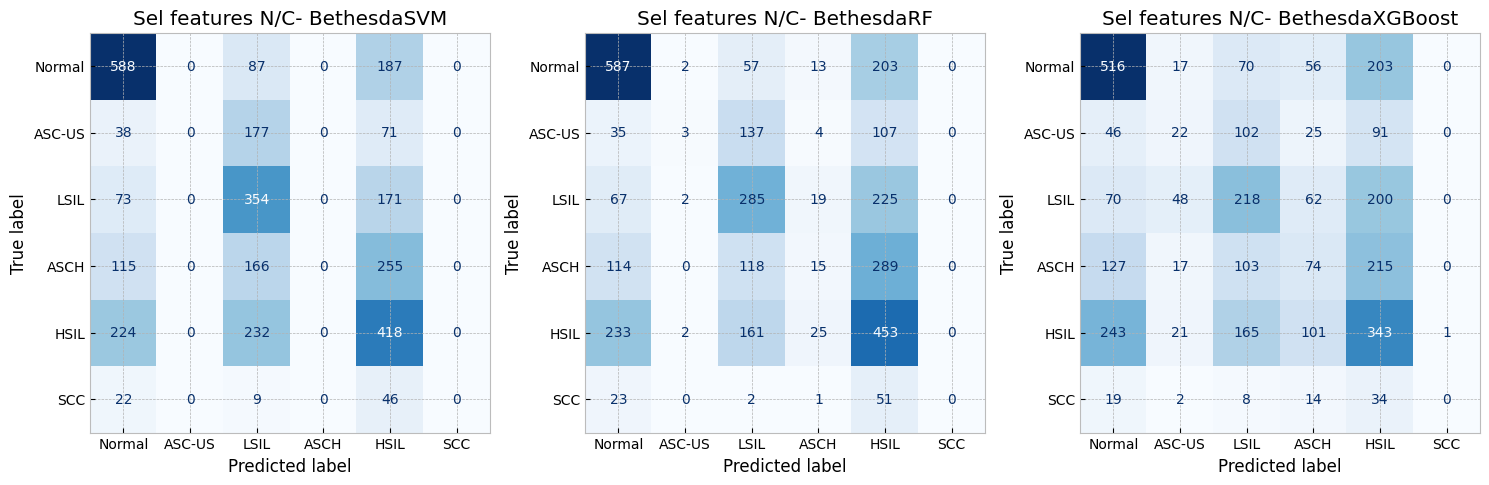

,Experiment,Model,Features,Accuracy,Precision,Recall,False Pos,False Neg,Specificity,F1_measure
0,bethesda,SVM,Sel features N/C,0.4207,0.3106,0.4207,0.0995,0.5793,0.9005,0.3552
1,bethesda,RF,Sel features N/C,0.4154,0.3633,0.4154,0.1005,0.5846,0.8995,0.3613
2,bethesda,XGBoost,Sel features N/C,0.3628,0.3328,0.3628,0.1243,0.6372,0.8757,0.3411


In [16]:
# Show Confusion Matrix:
functions.plot_conf_matrix(conf_matrix_list, lbls=[0,1,2,3,4,5], disp_lbls=['Normal', 'ASC-US','LSIL','ASCH', 'HSIL', 'SCC'])
results